In [1]:
%load_ext dotenv
%reload_ext dotenv
%dotenv

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [4]:
import sys
import os
from os.path import dirname

UTILS_PATH=os.environ.get('REPO') + "/notebooks/commons"
sys.path.append(dirname(UTILS_PATH))

from commons import check_args, gen_paths
from commons import coordinates_bounds, plot_feature_importances
from commons import check_args_variables, gen_paths_variables

In [5]:
def load_posts(source_path, clean_path):
    external = pd.read_parquet(source_path)
    external.loc[:, "lat"] = external["lat"].apply(float)
    external.loc[:, "lon"] = external["lon"].apply(float)
    
    fincaraiz = pd.read_parquet(clean_path)
    return external, fincaraiz

In [6]:
if __name__ == "__main__":
    source = "OSM"
    city = "manizales"
    
    property_type = "casas"
    post_type = "arriendo"
    
    base_path = os.environ.get('REPO')
    
    source_path = base_path + gen_paths_variables(source, city)
    raw_path, clean_path = gen_paths(city, property_type, post_type)
        
    raw_path = base_path + raw_path
    clean_path = base_path + clean_path

In [7]:
external_variables, fincaraiz = load_posts(source_path, clean_path)

In [8]:
from math import cos, asin, sqrt
def distance(lat1, lon1, lat2, lon2):
    """
    El resultado de la medición de distancia esta en kilometros.
    """
    p = 0.017453292519943295     #Pi/180
    a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    return 12742 * asin(sqrt(a))

def post_to_place_distance(publications, places, index):
    publication = publications.loc[index]
    
    places_to_point = places.copy()
    places_to_point.loc[:, "fid"] = publication["fid"]
    
    places_to_point.loc[:, "latitide"] = publication["latitude"]
    places_to_point.loc[:, "longitude"] = publication["longitude"]
    
    places_to_point.loc[:, "distance"] = places_to_point.apply(
        lambda e: distance(publication["latitude"], publication["longitude"], e["lat"], e["lon"]), axis=1)
        
    return places_to_point

import functools
from multiprocessing import Pool
def get_near_points(external_variables, fincaraiz):    
    distance_map = functools.partial(
        post_to_place_distance, 
        fincaraiz, external_variables)
    
    pool = Pool(8)
    distances = pool.map(
        distance_map,
        fincaraiz.index
    )

    return pd.concat(distances).reset_index(drop=True)

In [9]:
distances_map = get_near_points(external_variables, fincaraiz)
distances_map.head()

,lat,lon,name,amenity,fid,latitide,longitude,distance
0,5.064422,-75.495189,CAI La Leonora,police,3078558,5.06864,-75.517929,2.561958
1,5.064628,-75.497428,101 Perros,fast_food,3078558,5.06864,-75.517929,2.314133
2,5.061315,-75.490434,Universidad de Caldas - Sede Palogrande,university,3078558,5.06864,-75.517929,3.152369
3,5.071657,-75.517147,None,marketplace,3078558,5.06864,-75.517929,0.346550
4,5.066886,-75.504299,Universidad Autónoma de Manizales,university,3078558,5.06864,-75.517929,1.522223


In [10]:
distances_map.loc[distances_map["distance"] == distances_map["distance"].min()]

,lat,lon,name,amenity,fid,latitide,longitude,distance
66670,5.067231,-75.513146,None,telephone,2146685,5.067263,-75.513145,0.003605


In [11]:
## Un punto de interes es cercano a la publicicación cuando esta a menos de 3 kilometros

near_points = distances_map.loc[distances_map["distance"] < 3]
near_points.head()

,lat,lon,name,amenity,fid,latitide,longitude,distance
0,5.064422,-75.495189,CAI La Leonora,police,3078558,5.06864,-75.517929,2.561958
1,5.064628,-75.497428,101 Perros,fast_food,3078558,5.06864,-75.517929,2.314133
3,5.071657,-75.517147,None,marketplace,3078558,5.06864,-75.517929,0.346550
4,5.066886,-75.504299,Universidad Autónoma de Manizales,university,3078558,5.06864,-75.517929,1.522223
5,5.063438,-75.499609,Universidad de Caldas - Facultad de Ciencias p...,university,3078558,5.06864,-75.517929,2.109962


In [12]:
near_points.describe()

,lat,lon,latitide,longitude,distance
count,37675.000000,37675.000000,37675.000000,37675.000000,37675.000000
mean,5.059203,-75.500340,5.058338,-75.497458,1.553883
std,0.008931,0.014238,0.007903,0.014524,0.849649
min,5.028542,-75.554942,5.029500,-75.546356,0.003605
25%,5.054906,-75.513021,5.052755,-75.509628,0.775852
50%,5.061354,-75.499105,5.058971,-75.493362,1.554840
75%,5.067094,-75.488346,5.064198,-75.487366,2.281602
max,5.096118,-75.445525,5.091370,-75.457062,2.999826


In [13]:
near_points_by_categories = near_points[["fid", "amenity", "name"]].groupby(["fid", "amenity"]).count()
near_points_by_categories.head()

name
fid     amenity          
2146685 arts_centre     1
        atm             0
        bank           27
        bar             7
        bench           0

In [14]:
index = list(zip(*near_points_by_categories.index))
near_points_by_categories.loc[:, "fid"] = index[0]
near_points_by_categories.loc[:, "amenity"] = index[1]
near_points_by_categories.loc[:, "count"] = near_points_by_categories["name"]

near_points_by_categories = near_points_by_categories.reset_index(drop=True)
near_points_by_categories = near_points_by_categories.drop(["name"], axis=1)
near_points_by_categories.head()

,fid,amenity,count
0,2146685,arts_centre,1
1,2146685,atm,0
2,2146685,bank,27
3,2146685,bar,7
4,2146685,bench,0


In [15]:
posts_full = fincaraiz[["fid"]].copy()
posts_full = posts_full.drop_duplicates(["fid"])

def safe_get(post, amenity):
    client = near_points_by_categories.loc[
        near_points_by_categories["fid"] == post["fid"]]
    
    if client.shape[0] == 0:
        return 0
    
    client = client.loc[client["amenity"] == amenity]
    if client.shape[0] == 0:
        return 0
    
    return client["count"].iloc[0]

In [16]:
for amenity in external_variables["amenity"].value_counts().index:
    posts_full.loc[:, amenity] = posts_full.apply(lambda e: safe_get(e, amenity), axis=1)

In [18]:
## Las features y las etiquetas son las mismas en todos los métodos

FEATURES = list(filter(lambda e: e != "fid", posts_full.columns))
LABEL = "price"

final_features = pd.merge(posts_full, fincaraiz[["fid", "price"]], on="fid")

X = final_features[FEATURES].values
y = final_features[LABEL].values

## Selección de features univariada

In [19]:
selector = SelectKBest(f_regression, k=5)
X_new = selector.fit_transform(X, y)
X_new.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


(99, 5)

In [20]:
feature_importances = pd.DataFrame({'importance': selector.scores_, 'feature': FEATURES})

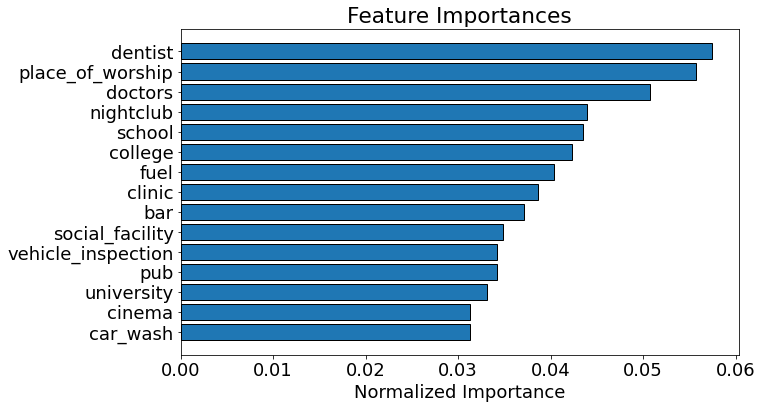

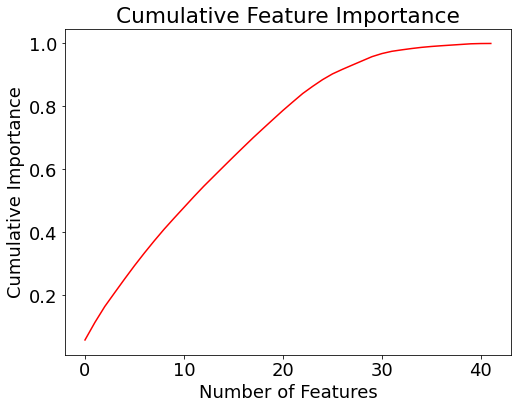

26 features required for 0.90 of cumulative importance


,index,importance,feature,importance_normalized,cumulative_importance
0,32,6.624432,dentist,0.057456,0.057456
1,9,6.425085,place_of_worship,0.055727,0.113183
2,23,5.848788,doctors,0.050729,0.163912
3,18,5.061953,nightclub,0.043904,0.207816
4,10,5.010455,school,0.043457,0.251273
5,31,4.881080,college,0.042335,0.293609
6,8,4.649980,fuel,0.040331,0.333940
7,36,4.460855,clinic,0.038691,0.372630
8,12,4.279285,bar,0.037116,0.409746
9,40,4.021854,social_facility,0.034883,0.444629


In [21]:
plot_feature_importances(feature_importances)

## Eliminación recursiva de features

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

In [23]:
reg = LinearRegression().fit(X, y)
reg.score(X, y)

-0.06410105542775169

In [24]:
rfe = RFE(estimator=reg, n_features_to_select=1, step=1)
rfe.fit(X, y)

RFE(estimator=LinearRegression(), n_features_to_select=1)

In [25]:
feature_importances = pd.DataFrame({'importance': rfe.ranking_, 'feature': FEATURES})

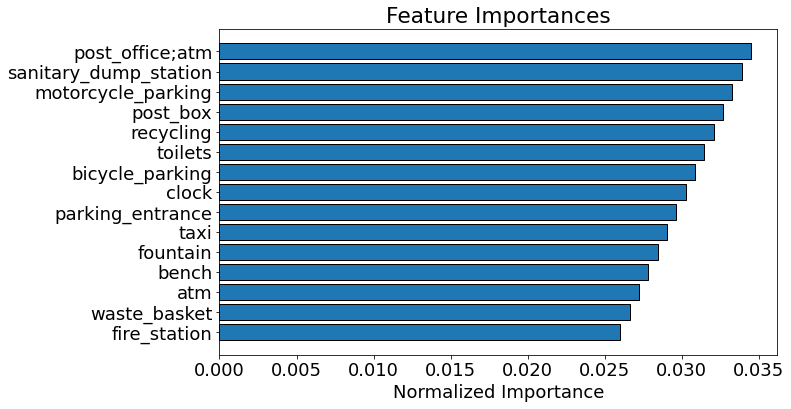

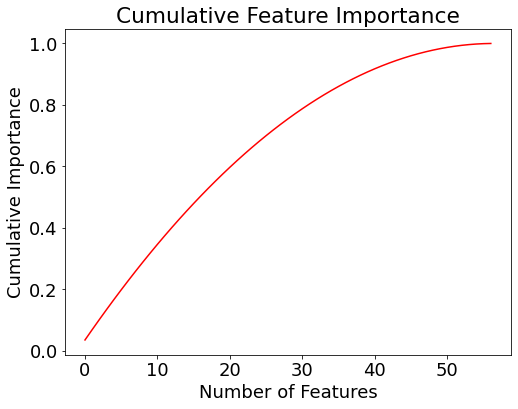

40 features required for 0.90 of cumulative importance


,index,importance,feature,importance_normalized,cumulative_importance
0,53,57,post_office;atm,0.034483,0.034483
1,52,56,sanitary_dump_station,0.033878,0.068361
2,48,55,motorcycle_parking,0.033273,0.101633
3,46,54,post_box,0.032668,0.134301
4,37,53,recycling,0.032063,0.166364
5,22,52,toilets,0.031458,0.197822
6,7,51,bicycle_parking,0.030853,0.228675
7,24,50,clock,0.030248,0.258923
8,16,49,parking_entrance,0.029643,0.288566
9,29,48,taxi,0.029038,0.317604


In [26]:
plot_feature_importances(feature_importances)

## Selección de features basada en arboles

In [27]:
from sklearn.ensemble import ExtraTreesRegressor

In [28]:
forest = ExtraTreesRegressor(n_estimators=100, random_state=0)
forest.fit(X, y)

ExtraTreesRegressor(random_state=0)

In [29]:
feature_importances = pd.DataFrame({'importance':  forest.feature_importances_, 'feature': FEATURES})

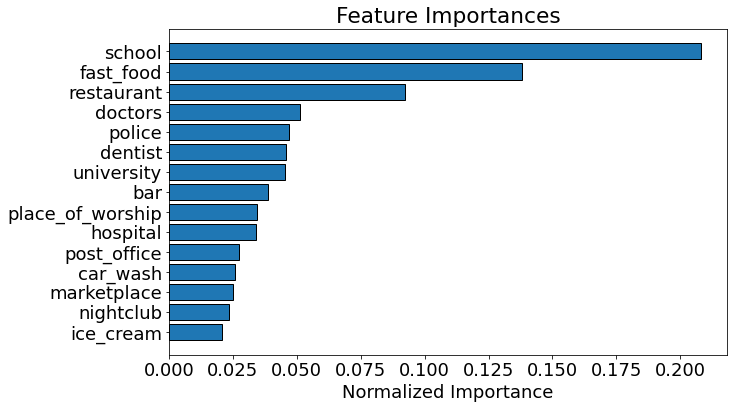

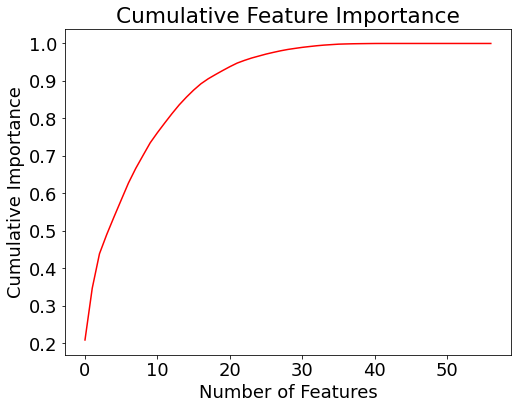

18 features required for 0.90 of cumulative importance


,index,importance,feature,importance_normalized,cumulative_importance
0,10,0.207923,school,0.207923,0.207923
1,4,0.138196,fast_food,0.138196,0.346119
2,2,0.092185,restaurant,0.092185,0.438305
3,23,0.051352,doctors,0.051352,0.489657
4,26,0.046795,police,0.046795,0.536452
5,32,0.045564,dentist,0.045564,0.582017
6,28,0.045263,university,0.045263,0.627279
7,12,0.038859,bar,0.038859,0.666138
8,9,0.034480,place_of_worship,0.034480,0.700619
9,17,0.034074,hospital,0.034074,0.734692


In [30]:
plot_feature_importances(feature_importances)